# Pipeline for High-z Radio Galaxies I: AGN/Galaxy classification

## Introduction

Training for classification of AGN and galaxies will be done in the HETDEX Field.  

Sources are all elements detected in the CatWISE2020 catalogue.  But classification  
will be done with AGN from the Million Quasar Catalog (MQC) and galaxies from  
spectroscopically detected sources in SDSS DR16 (Spectral Class = "GALAXY").

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import pacmap
from pycaret import classification as pyc
# from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Methdods for PyCaret and saved models.

In [6]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [7]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

***

## Reading data

In [8]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [82]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

In [10]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [11]:
mqc_version = '7_4d'  # '7_2'

In [12]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [14]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'Z', 'X_ray_detect', 'radio_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'mode',\
                     'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [15]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [16]:
# full_catalog_df.describe()

#### Select only confirmed galaxies and AGN

In [ ]:
full_catalog_df.loc[:, 'is_gal']
full_catalog_df.loc[:, 'is_AGN']

In [17]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
print(f'In this dataset, with {len(full_catalog_df.loc[:, "is_AGN"])} elements, {n_is_AGN} of them are marked as AGN.')

In this dataset, with 6729647 elements, 30395 of them are marked as AGN.


---

## Possible correlations

In [18]:
print(full_catalog_df.columns.to_list())

['band_num', 'is_AGN', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'FUVmag', 'NUVmag', 'Jmag', 'Hmag', 'Kmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'g_r', 'r_i', 'i_z', 'z_y', 'g_i', 'w1_w2', 'w2_w3', 'w3_w4', 'J_H', 'H_K', 'FUV_NUV', 'r/z', 'i/y', 'w1/w3', 'w1/w4', 'w2/w4', 'J/K', 'FUV/K', 'g/J', 'r/H', 'i/K', 'z/W1', 'y/W2']


---

## Random seed

In [19]:
seed = 42

## Split data: Test, Train, Validation

In [20]:
# data_train_test_AGN_df = full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_AGN'] == 1), :]  # Train + test sets
data_train_test_AGN_df = full_catalog_df.sample(frac=0.9, random_state=seed)  # Train + test sets
data_validation_AGN_df = full_catalog_df.drop(data_train_test_AGN_df.index)  # Validation data

print('Shape of used data')
print('-' * 40)
print(f'Full Dataset size: {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {data_train_test_AGN_df.shape}')
print(f'Unseen Data For Validation: {data_validation_AGN_df.shape}')
print('-' * 40)

Shape of used data
----------------------------------------
Full Dataset size: (6729647, 41)
Data for Modeling (Train and Test): (6056682, 41)
Unseen Data For Validation: (672965, 41)
----------------------------------------


---

## Use Correlation matrix to discard some features

In [21]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(data_train_test_AGN_df.values)
norm_data_train_test_AGN_df = pd.DataFrame(data=full_scaled, columns=data_train_test_AGN_df.columns, index=data_train_test_AGN_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [22]:
rsd_vals = (norm_data_train_test_AGN_df.std() / norm_data_train_test_AGN_df.mean() * 100).sort_values(ascending=False)

In [23]:
rsd_vals

is_AGN      1484.568180
band_num      96.921317
w1_w2         11.514514
imag          10.244659
i/K            9.798090
zmag           9.174391
z/W1           9.106722
rmag           9.004916
r/H            8.822793
ymag           7.688826
w1/w3          7.500195
w1/w4          7.321475
gmag           6.922821
W1mproPM       6.090751
y/W2           6.003216
FUV/K          5.714314
g/J            5.700751
w2_w3          5.442239
w2/w4          5.428985
W1mag          5.275838
i/y            4.751556
W2mproPM       4.501499
g_i            4.202821
W2mag          4.049570
r/z            3.584821
z_y            3.415892
r_i            3.329061
Jmag           3.285824
Hmag           3.166392
g_r            3.122518
i_z            3.020600
FUV_NUV        2.965446
Kmag           2.406068
w3_w4          2.240411
J/K            1.803372
NUVmag         1.719729
W3mag          1.633552
H_K            1.461627
J_H            0.936767
W4mag          0.555059
FUVmag         0.494752
dtype: float64

In [24]:
correlation = norm_data_train_test_AGN_df.corr()

In [25]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [26]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [27]:
target_feat = 'is_AGN'

In [28]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [29]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [30]:
list_drop_corr

['W1mproPM',
 'W2mproPM',
 'Hmag',
 'w1/w4',
 'i/K',
 'w2/w4',
 'NUVmag',
 'Kmag',
 'H_K',
 'r/H',
 'zmag',
 'W3mag',
 'W2mag',
 'g/J',
 'rmag',
 'w2_w3',
 'y/W2',
 'Jmag',
 'ymag',
 'W1mag',
 'gmag',
 'imag',
 'w1/w3',
 'z_y']

In [31]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [32]:
norm_train_test_discard = norm_data_train_test_AGN_df.drop(columns=list_drop_corr)

In [33]:
corr_discard = norm_train_test_discard.corr()

In [34]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

band_num  band_num    1.000000
g_r       g_i         0.741976
i/y       i_z         0.696228
J/K       J_H         0.691816
g_i       r_i         0.690341
band_num  w1_w2       0.674938
FUV/K     J/K         0.631667
z/W1      band_num    0.627424
i/y       g_i         0.625818
r/z       r_i         0.624502
band_num  g_i         0.565721
          i/y         0.560653
FUV/K     FUV_NUV     0.528009
i_z       g_i         0.509997
FUV/K     w3_w4       0.504258
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

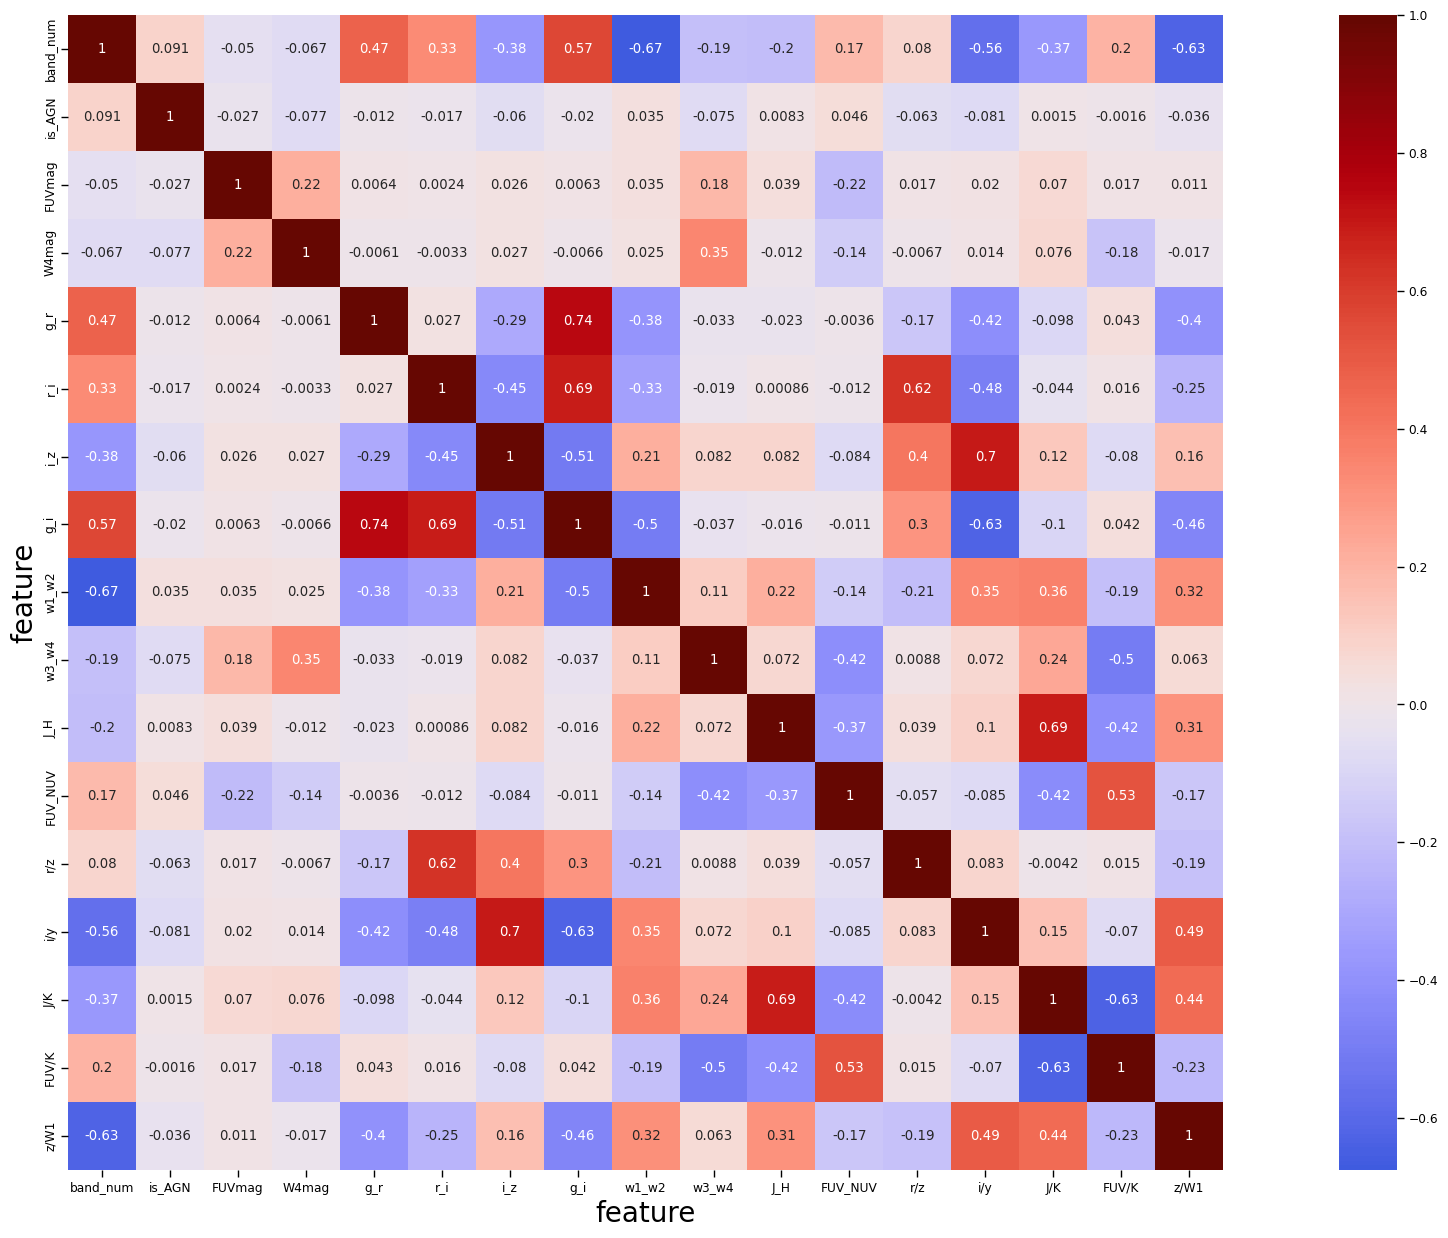

In [35]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [36]:
norm_train_test_discard.loc[:, 'is_AGN'] = norm_train_test_discard.loc[:, 'is_AGN'].astype(bool)

In [37]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [38]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
FUV/K     FUV/K       1.000000
g_i       i/y         0.586456
i_z       i/y         0.576010
r_i       i/y         0.568685
          g_i         0.555609
band_num  i/y         0.523532
          g_i         0.506684
i_z       g_i         0.477340
i/y       g_i         0.466337
r/z       i/y         0.442506
J_H       J/K         0.436112
r/z       g_i         0.398263
g_r       g_i         0.373952
band_num  z/W1        0.361820
          i_z         0.353687
r/z       r_i         0.335130
          i_z         0.323917
z/W1      band_num    0.319025
band_num  g_r         0.298379
z/W1      w1_w2       0.295202
dtype: float64

In [39]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [40]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [41]:
target_feat = 'is_AGN'

In [42]:
list_drop_pps = []

In [43]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [44]:
list_drop_pps

[]

In [45]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [46]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'is_AGN', random_seed=seed)

In [47]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,is_AGN,0.000004,classification,True,weighted F1,0.993105,0.993105,DecisionTreeClassifier()
1,FUVmag,is_AGN,0.000004,classification,True,weighted F1,0.993105,0.993105,DecisionTreeClassifier()
2,W4mag,is_AGN,0.000004,classification,True,weighted F1,0.993105,0.993105,DecisionTreeClassifier()
3,J_H,is_AGN,0.000004,classification,True,weighted F1,0.993105,0.993105,DecisionTreeClassifier()
4,J/K,is_AGN,0.000004,classification,True,weighted F1,0.993105,0.993105,DecisionTreeClassifier()
5,FUV/K,is_AGN,0.000004,classification,True,weighted F1,0.993105,0.993105,DecisionTreeClassifier()
6,g_r,is_AGN,0.000000,classification,True,weighted F1,0.993105,0.991974,DecisionTreeClassifier()
7,r_i,is_AGN,0.000000,classification,True,weighted F1,0.993105,0.991200,DecisionTreeClassifier()
8,i_z,is_AGN,0.000000,classification,True,weighted F1,0.993105,0.990900,DecisionTreeClassifier()
9,g_i,is_AGN,0.000000,classification,True,weighted F1,0.993105,0.991502,DecisionTreeClassifier()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [48]:
# final_feats = pps_pred_target.x.to_list()  # Before Boruta
if mqc_version == '7_2':
    final_feats = ['band_num', 'W4mag', 'g_r', 'r_i', 'i_z', 'g_i', 'w1_w2',\
                   'w3_w4', 'J_H', 'FUV_NUV', 'r/z', 'i/y', 'J/K', 'FUV/K']  # After Boruta
if mqc_version == '7_4d':
    final_feats = ['band_num', 'FUVmag', 'W4mag', 'g_r', 'r_i', 'i_z',\
                   'g_i', 'w1_w2', 'w3_w4', 'J_H', 'FUV_NUV', 'r/z',\
                   'i/y', 'J/K', 'FUV/K', 'z/W1']  # After Boruta

In [49]:
if mqc_version == '7_2':
    feats_2_discard = list_drop_corr + list_drop_pps + ['FUVmag']
if mqc_version == '7_4d':
    feats_2_discard = list_drop_corr + list_drop_pps
# final_feats.remove()  # After Boruta

Boruta discards one feature.

In [50]:
exp_AGN = pyc.setup(data=data_train_test_AGN_df, target='is_AGN', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard,\
                    transformation=True, transformation_method='yeo-johnson', n_jobs=12,\
                    normalize=True, normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,is_AGN
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(6056682, 41)"
5,Missing Values,False
6,Numeric Features,16
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [51]:
pyc.get_config('X').columns

Index(['band_num', 'FUVmag', 'W4mag', 'g_r', 'r_i', 'i_z', 'g_i', 'w1_w2',
       'w3_w4', 'J_H', 'FUV_NUV', 'r/z', 'i/y', 'J/K', 'FUV/K', 'z/W1'],
      dtype='object')

In [52]:
pyc.models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [53]:
# Catboost uses GPU only if rows > 50000
# gpu_ready_models_clf = ['lr', 'knn', 'svm', 'ridge', 'rf', 'xgboost', 'lightgbm', 'catboost']  # Catboost too slow
used_models_clf      = ['catboost','xgboost', 'lightgbm', 'rf', 'et', 'lr', 'dt', 'svm', 'lda']  # knn too slow, ridge does not work
# fast_selection_clf   = ['xgboost', 'catboost', 'rf', 'et', 'lightgbm']
if mqc_version == '7_2':
    final_selection_clf  = ['xgboost', 'catboost', 'rf']
    n_models             = 3
if mqc_version == '7_4d':
    final_selection_clf  = ['xgboost', 'catboost', 'rf', 'et', 'lightgbm']
    n_models             = 5
top_model_AGN = pyc.compare_models(n_select=n_models, include=final_selection_clf, sort='MCC')  # 1:15 hour for used_models_clf

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9972,0.9796,0.5077,0.8126,0.6248,0.6235,0.6410,62.6890
catboost,CatBoost Classifier,0.9972,0.9783,0.5177,0.7934,0.6265,0.6252,0.6396,218.6450
rf,Random Forest Classifier,0.9972,0.9233,0.4778,0.8367,0.6082,0.6069,0.6311,72.6590
et,Extra Trees Classifier,0.9971,0.9224,0.4588,0.8358,0.5923,0.5910,0.6180,63.6400
lightgbm,Light Gradient Boosting Machine,0.9966,0.9076,0.4549,0.6889,0.5478,0.5461,0.5581,5.6290
dt,Decision Tree Classifier,0.9952,0.6296,0.4916,0.4728,0.4820,0.4796,0.4797,6.8180
lda,Linear Discriminant Analysis,0.9924,0.9334,0.3673,0.2618,0.3056,0.3019,0.3063,1.9250
lr,Logistic Regression,0.9955,0.9473,0.1047,0.5229,0.1744,0.1731,0.2325,3.7850
svm,SVM - Linear Kernel,0.9955,0.0000,0.0778,0.3550,0.1245,0.1237,0.1614,1.4990


Results from `compare_models` are with ad-hoc imputation are:  

|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9979  |0.9876|0.6146|0.8104|0.6989|0.6979|0.7047|92.2400 |
|**catboost**|CatBoost Classifier            |0.9978  |0.9859|0.6162|0.7928|0.6933|0.6922|0.6978|203.0220|
|**rf**      |Random Forest Classifier       |0.9978  |0.9632|0.5756|0.8353|0.6815|0.6804|0.6924|109.3340|
|**et**      |Extra Trees Classifier         |0.9978  |0.9674|0.5513|0.8511|0.6691|0.6680|0.6840|65.3530 |
|**lightgbm**|Light Gradient Boosting Machine|0.9969  |0.8978|0.5630|0.6439|0.6000|0.5984|0.6002|6.4480  |
|**svm**     |SVM - Linear Kernel            |0.9970  |0.0000|0.4770|0.6796|0.5601|0.5587|0.5677|1.6290  |
|**dt**      |Decision Tree Classifier       |0.9963  |0.7847|0.5713|0.5481|0.5593|0.5575|0.5577|9.7660  |
|**lr**      |Logistic Regression            |0.9970  |0.9778|0.4028|0.7356|0.5205|0.5192|0.5430|5.6770  |
|**lda**     |Linear Discriminant Analysis   |0.9920  |0.9700|0.4343|0.2367|0.3064|0.3027|0.3169|2.3460  |

Results from `compare_models` are with $5-\sigma$ imputation and Million Quasar Catalog version 7.2 are:  
    
|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9975  |0.9774|0.4876|0.8165|0.6105|0.6093|0.6298|53.4930 |
|**catboost**|CatBoost Classifier            |0.9974  |0.9756|0.4978|0.7911|0.6110|0.6098|0.6264|180.6900|
|**rf**      |Random Forest Classifier       |0.9975  |0.9137|0.4693|0.8284|0.5991|0.5979|0.6224|63.2750 |
|**et**      |Extra Trees Classifier         |0.9974  |0.9086|0.4424|0.8322|0.5776|0.5764|0.6056|54.2790 |
|**lightgbm**|Light Gradient Boosting Machine|0.9969  |0.9020|0.4499|0.6872|0.5435|0.5421|0.5545|5.5730  |
|**dt**      |Decision Tree Classifier       |0.9956  |0.6220|0.4813|0.4634|0.4721|0.4699|0.4700|5.5580  |
|**lda**     |Linear Discriminant Analysis   |0.9922  |0.9391|0.3916|0.2325|0.2915|0.2878|0.2979|1.8050  |
|**lr**      |Logistic Regression            |0.9960  |0.9523|0.1120|0.5521|0.1861|0.1850|0.2473|3.9970  |
|**svm**     |SVM - Linear Kernel            |0.9959  |0.0000|0.0225|0.0548|0.0319|0.0317|0.0348|1.4250  |

Results from `compare_models` are with $5-\sigma$ imputation and using Million Quasar Catalog version 7.4d are:  
    
|            |Model                          |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |TT (Sec)|
|------------|-------------------------------|--------|------|------|------|------|------|------|--------|
|**xgboost** |Extreme Gradient Boosting      |0.9972  |0.9796|0.5077|0.8126|0.6248|0.6235|0.6410|62.6890 |
|**catboost**|CatBoost Classifier            |0.9972  |0.9783|0.5177|0.7934|0.6265|0.6252|0.6396|218.6450|
|**rf**      |Random Forest Classifier       |0.9972  |0.9233|0.4778|0.8367|0.6082|0.6069|0.6311|72.6590 |
|**et**      |Extra Trees Classifier         |0.9971  |0.9224|0.4588|0.8358|0.5923|0.5910|0.6180|63.6400 |
|**lightgbm**|Light Gradient Boosting Machine|0.9966  |0.9076|0.4549|0.6889|0.5478|0.5461|0.5581|5.6290  |
|**dt**      |Decision Tree Classifier       |0.9952  |0.6296|0.4916|0.4728|0.4820|0.4796|0.4797|6.8180  |
|**lda**     |Linear Discriminant Analysis   |0.9924  |0.9334|0.3673|0.2618|0.3056|0.3019|0.3063|1.9250  |
|**lr**      |Logistic Regression            |0.9955  |0.9473|0.1047|0.5229|0.1744|0.1731|0.2325|3.7850  |
|**svm**     |SVM - Linear Kernel            |0.9955  |0.0000|0.0778|0.3550|0.1245|0.1237|0.1614|1.4990  |

Thus, we select `xgboost` as meta learner.

Thus, we stack the models.

In [55]:
stacked_model_AGN = pyc.stack_models(estimator_list=top_model_AGN[1:], meta_model=top_model_AGN[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9979,0.9874,0.6124,0.8158,0.6996,0.6986,0.7058
1,0.9979,0.9891,0.6351,0.8072,0.7109,0.7099,0.7150
2,0.9980,0.9893,0.6426,0.8303,0.7245,0.7236,0.7295
3,0.9979,0.9864,0.6258,0.8178,0.7090,0.7080,0.7144
4,0.9977,0.9852,0.6051,0.7888,0.6849,0.6837,0.6898
5,0.9979,0.9834,0.6185,0.8124,0.7023,0.7012,0.7078
6,0.9979,0.9887,0.6254,0.8073,0.7048,0.7038,0.7096
7,0.9979,0.9871,0.6165,0.8137,0.7015,0.7004,0.7072
8,0.9979,0.9867,0.6345,0.8137,0.7130,0.7120,0.7176
9,0.9979,0.9888,0.6380,0.8032,0.7111,0.7101,0.7148


In [56]:
# tuned_AGN_clf = pyc.tune_model(top_model_AGN, early_stopping='asha', optimize='MCC')  #  minutes
tuned_AGN_clf = pyc.tune_model(stacked_model_AGN, early_stopping='asha', optimize='MCC')  #  minutes

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9978,0.9838,0.6630,0.7607,0.7085,0.7074,0.7091
1,0.9978,0.9834,0.6967,0.7541,0.7243,0.7232,0.7237
2,0.9980,0.9798,0.7077,0.7689,0.7371,0.7360,0.7367
3,0.9978,0.9778,0.6845,0.7576,0.7192,0.7181,0.7190
4,0.9977,0.9741,0.6551,0.7431,0.6963,0.6951,0.6965
5,0.9978,0.9753,0.6684,0.7592,0.7109,0.7098,0.7113
6,0.9978,0.9795,0.6754,0.7596,0.7150,0.7139,0.7152
7,0.9978,0.9788,0.6688,0.7562,0.7098,0.7087,0.7101
8,0.9979,0.9786,0.6926,0.7617,0.7255,0.7244,0.7253
9,0.9978,0.9804,0.6944,0.7525,0.7223,0.7212,0.7218


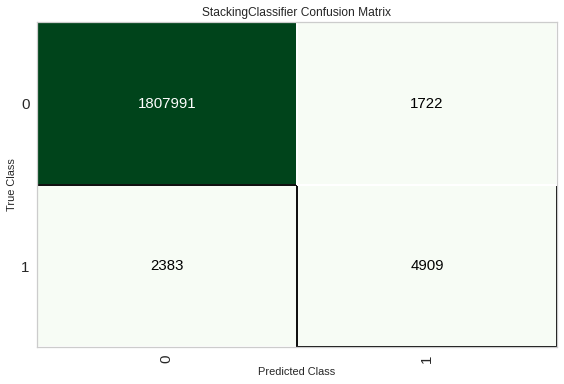

In [57]:
pyc.plot_model(tuned_AGN_clf, plot='confusion_matrix')

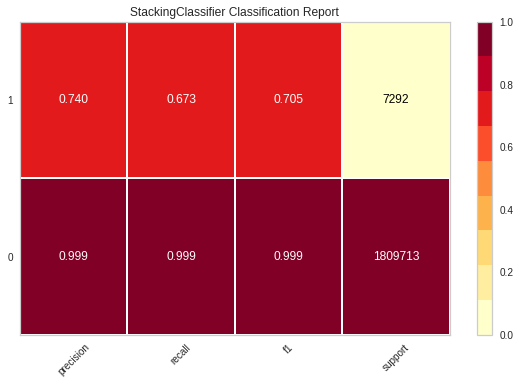

In [58]:
pyc.plot_model(tuned_AGN_clf, plot='class_report')

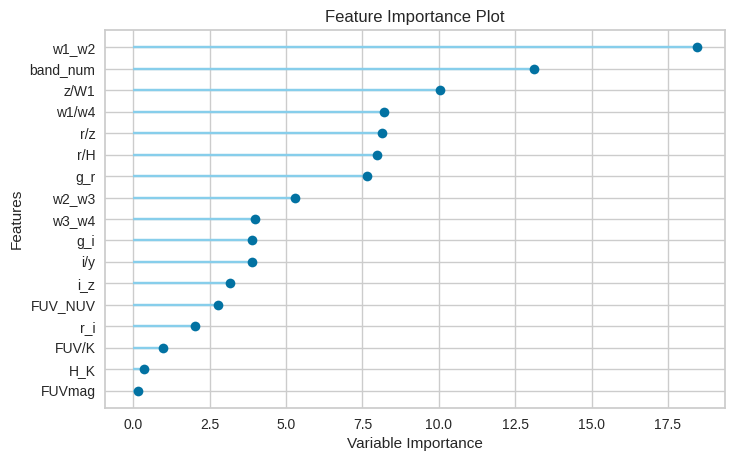

In [59]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='threshold')

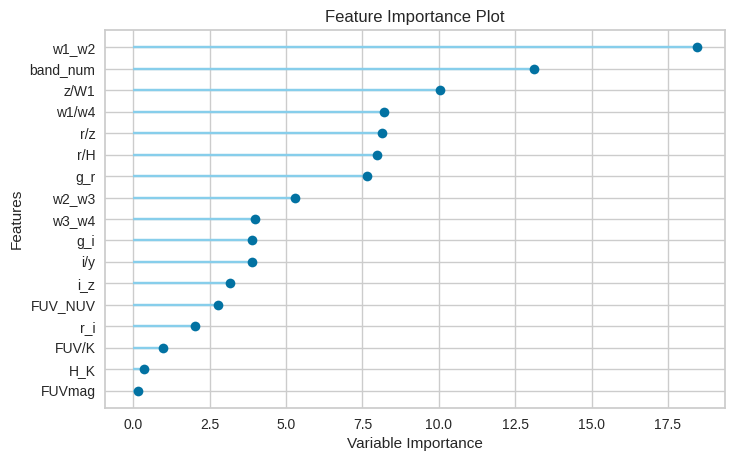

In [59]:
pyc.plot_model(tuned_AGN_clf.estimators_[0], plot='feature_all')

In [60]:
pyc.plot_model(tuned_AGN_clf, plot='parameter')

,Parameters
cv,"StratifiedKFold(n_splits=10,\n random_s..."
estimators,"[('catboost', <catboost.core.CatBoostClassifie..."
final_estimator,"XGBClassifier(base_score=0.5, booster='gbtree'..."
n_jobs,12
passthrough,True
stack_method,auto
verbose,0


In [61]:
plt.rcParams.update(plt.rcParamsDefault)

In [62]:
pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9977,0.9780,0.6736,0.7384,0.7045,0.7034,0.7041


,band_num,FUVmag,g_r,r_i,i_z,g_i,w1_w2,w2_w3,w3_w4,H_K,...,r/z,i/y,w1/w4,FUV/K,r/H,z/W1,is_AGN,Label,Score_0,Score_1
0,-1.145079,0.118051,-0.441496,-0.414804,0.484870,-0.621312,0.829487,0.491603,-0.163208,0.081579,...,-0.026053,0.662185,0.208195,-0.079818,0.595025,-0.192464,0,0,0.5,0.5
1,-1.145079,0.118051,-0.441496,-0.414804,0.484870,-0.621312,0.835671,0.491603,-0.163208,0.081579,...,-0.026053,0.662185,0.455998,-0.079818,0.595025,-0.371136,0,0,0.5,0.5
2,0.923933,0.118051,-0.441496,2.043164,-1.142193,1.182423,0.145127,0.016518,1.924873,0.081579,...,1.131339,-1.027090,2.074166,-0.079818,0.595025,0.081395,0,0,0.5,0.5
3,-1.145079,0.118051,-0.441496,-0.414804,0.484870,-0.621312,1.244485,0.491603,-0.163208,0.081579,...,-0.026053,0.662185,0.687731,-0.079818,0.595025,-0.524271,0,0,0.5,0.5
4,0.229464,0.118051,-0.441496,-0.414804,0.484870,-0.621312,1.015121,1.112446,0.319964,0.081579,...,-0.026053,0.662185,1.180247,-0.079818,0.595025,0.747166,0,0,0.5,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1817000,-1.145079,0.118051,-0.441496,-0.414804,0.484870,-0.621312,-0.092303,0.491603,-0.163208,0.081579,...,-0.026053,0.662185,-1.314701,-0.079818,0.595025,1.601069,0,0,0.5,0.5
1817001,0.229464,0.118051,-0.441496,-0.414804,0.484870,-0.621312,0.394868,0.819670,-0.526388,0.081579,...,-0.026053,0.662185,0.351924,-0.079818,0.595025,0.793904,0,0,0.5,0.5
1817002,1.297614,0.118051,0.464435,0.086001,-0.449426,0.436799,0.055558,-0.577332,-0.456921,0.081579,...,-0.210268,-1.015671,-0.414600,-0.079818,-1.397428,-0.734389,0,0,0.5,0.5
1817003,0.485678,0.118051,-0.441496,-0.414804,0.484870,-0.621312,1.197064,-1.006604,-0.702779,0.081579,...,-0.026053,0.662185,-0.086892,-0.079818,0.595025,1.759593,0,0,0.5,0.5


In [63]:
test_prediction_clf = pyc.predict_model(tuned_AGN_clf, probability_threshold=0.5, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.9977,0.9780,0.6736,0.7384,0.7045,0.7034,0.7041


Metrics from applying model to test data.  

|Model                    |Accuracy|AUC   |Recall|Prec. |F1    |Kappa |MCC   |
|-------------------------|--------|------|------|------|------|------|------|
|Extreme Gradient Boosting|0.9978  |0.9781|0.5978|0.8092|0.6876|0.6865|0.6945|

In [64]:
final_AGN_clf = pyc.finalize_model(tuned_AGN_clf)

/home/rcarvajal/.anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/rcarvajal/.anaconda3/lib/python3.8/site-packages/xgboost/sklea

In [65]:
# pyc.save_model(final_AGN_clf, '../../models/model_final_HETDEX_AGN_detect_nov_27_2021')  # Model (it will be saved with .pkl extension)
# pyc.save_config('../../models/config_final_HETDEX_AGN_detect_nov_27_2021')  # Configuration file
if save_model_flag:
    if use_5sigma:
        if mqc_version == '7_2':
            pyc.save_model(final_AGN_clf, '../../models/model_final_HETDEX_AGN_detect_mar_15_2022')  # Model (it will be saved with .pkl extension)
            # pyc.save_config('../../models/config_final_HETDEX_AGN_detect_mar_15_2022')  # Configuration file
        if mqc_version == '7_4d':
            pyc.save_model(final_AGN_clf, '../../models/model_final_HETDEX_AGN_detect_mar_28_2022')  # Model (it will be saved with .pkl extension)
            # pyc.save_config('../../models/config_final_HETDEX_AGN_detect_mar_28_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['Hmag', 'Kmag', 'W2mag',
                                                        'zmag', 'rmag', 'Jmag',
                                                        'W2mproPM', 'w1/w3',
                                                        'i/K', 'NUVmag', 'ymag',
                                                        'J/K', 'w2/w4', 'W1mag',
                                                        'gmag', 'W4mag', 'imag',
                                                        'g/J', 'W1mproPM',
                                                        'y/W2', 'J_H', 'z_y',
                                                        'W3mag'],
                                       id_columns=[],
                                       ml_usecase='classification',
   

## Load Models

AGN detection model.

In [49]:
if load_model_flag:
    # final_AGN_clf = pyc.load_model('../../models/model_final_HETDEX_AGN_detect_nov_27_2021')
    if use_5sigma:
        if mqc_version == '7_2':
            final_AGN_clf = pyc.load_model('../../models/model_final_HETDEX_AGN_detect_mar_15_2022')
        if mqc_version == '7_4d':
            final_AGN_clf = pyc.load_model('../../models/model_final_HETDEX_AGN_detect_mar_28_2022')

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [50]:
extended_data_AGN = data_validation_AGN_df.loc[:, final_AGN_clf.named_steps['dtypes'].numerical_features].copy()
extended_idx_AGN  = extended_data_AGN.index
initial_cols_AGN  = extended_data_AGN.columns
if mqc_version == '7_2':
    extended_cols_AGN = extended_data_AGN.columns.insert(0, 'catboost')
    extended_cols_AGN = extended_cols_AGN.insert(0, 'rf')
if mqc_version == '7_4d':
    extended_cols_AGN = extended_data_AGN.columns.insert(0, 'catboost')
    extended_cols_AGN = extended_cols_AGN.insert(0, 'rf')
    extended_cols_AGN = extended_cols_AGN.insert(0, 'et')
    extended_cols_AGN = extended_cols_AGN.insert(0, 'lightgbm')

In [51]:
print('Running data pre-processing:\n')
for (name, method) in final_AGN_clf.named_steps.items():
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_AGN = method.transform(extended_data_AGN)
extended_data_AGN_df = pd.DataFrame(extended_data_AGN, columns=extended_cols_AGN, index=extended_idx_AGN)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


In [52]:
coef_meta_df = pd.DataFrame({'Feature': extended_cols_AGN, 'Importance': final_AGN_clf.named_steps['trained_model'].final_estimator_.feature_importances_})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [53]:
base_models_names = [model[0] for model in final_AGN_clf.named_steps['trained_model'].estimators]

In [54]:
coef_sorted_base_df = {}

In [55]:
for model, model_fit in zip(base_models_names, final_AGN_clf.named_steps['trained_model'].estimators_):
    coef_base_df = pd.DataFrame({'Feature': extended_cols_AGN.drop(base_models_names),
                                 'Importance': model_fit.feature_importances_})
    coef_sorted_base_df[model] = (
    coef_base_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_AGN.drop(base_models_names)))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [56]:
print('Feature importances scaled in [1,100]')
coef_sorted_base_df_copy = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy.keys():
    print(key)
    coef_sorted_base_df_copy[key].loc[:, 'Importance'] = (coef_sorted_base_df[key].loc[:, 'Importance'] -\
                                                     coef_sorted_base_df[key].loc[:, 'Importance'].min()) /\
                                                    (coef_sorted_base_df[key].loc[:, 'Importance'].max() -\
                                                     coef_sorted_base_df[key].loc[:, 'Importance'].min()) * (100 - 1) + 1
    display(coef_sorted_base_df_copy[key])

Feature importances scaled in [1,100]
catboost


,Feature,Importance
0,z/W1,100.000000
1,w1_w2,64.252976
2,band_num,49.276140
3,r_i,42.543365
4,g_r,32.576977
5,g_i,30.234938
6,r/z,29.526132
7,i/y,23.398688
8,i_z,18.744466
9,J/K,8.328392


rf


,Feature,Importance
0,w1_w2,100.000000
1,z/W1,41.267679
2,g_i,38.657070
3,r/z,38.342690
4,g_r,35.276983
5,i_z,33.274530
6,i/y,32.522912
7,r_i,30.137274
8,band_num,25.480416
9,w3_w4,6.183515


et


,Feature,Importance
0,w1_w2,100.000000
1,g_i,38.973255
2,z/W1,37.519694
3,g_r,32.777699
4,r/z,29.507592
5,i/y,27.847103
6,r_i,27.435078
7,i_z,26.262393
8,band_num,16.485226
9,w3_w4,6.818259


lightgbm


,Feature,Importance
0,w1_w2,100.000000
1,z/W1,81.253191
2,g_i,80.200000
3,r/z,67.982979
4,g_r,56.397872
5,band_num,55.765957
6,i/y,53.027660
7,i_z,45.655319
8,r_i,42.285106
9,FUV_NUV,22.695745


In [57]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(key)
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    display(coef_sorted_base_df_copy_sum[key])

Feature importances scaled to sum 100
catboost


,Feature,Importance
0,z/W1,23.840773
1,w1_w2,15.318406
2,band_num,11.747813
3,r_i,10.142667
4,g_r,7.766603
5,g_i,7.208243
6,r/z,7.039258
7,i/y,5.578428
8,i_z,4.468826
9,J/K,1.985553


rf


,Feature,Importance
0,w1_w2,25.244855
1,z/W1,10.417966
2,g_i,9.758921
3,r/z,9.679557
4,g_r,8.905623
5,i_z,8.400107
6,i/y,8.210362
7,r_i,7.608111
8,band_num,6.432494
9,w3_w4,1.561019


et


,Feature,Importance
0,w1_w2,27.711810
1,g_i,10.800194
2,z/W1,10.397386
3,g_r,9.083294
4,r/z,8.177088
5,i/y,7.716936
6,r_i,7.602757
7,i_z,7.277784
8,band_num,4.568354
9,w3_w4,1.889463


lightgbm


,Feature,Importance
0,w1_w2,15.514828
1,z/W1,12.606293
2,g_i,12.442892
3,r/z,10.547442
4,g_r,8.750033
5,band_num,8.651993
6,i/y,8.227150
7,i_z,7.083344
8,r_i,6.560462
9,FUV_NUV,3.521206


In [58]:
print('Feature importances scaled in [1,100]')
coef_sorted_meta_df_copy = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy.loc[:, 'Importance'] = (coef_sorted_meta_df.loc[:, 'Importance'] -\
                                                 coef_sorted_meta_df.loc[:, 'Importance'].min()) /\
                                                (coef_sorted_meta_df.loc[:, 'Importance'].max() -\
                                                 coef_sorted_meta_df.loc[:, 'Importance'].min()) * (100 - 1) + 1
print('Meta model')
display(coef_sorted_meta_df_copy)

Feature importances scaled in [1,100]
Meta model


,Feature,Importance
0,lightgbm,100.000000
1,rf,47.972462
2,catboost,20.942572
3,et,13.421138
4,w1_w2,3.430240
5,band_num,1.745128
6,FUV_NUV,1.541613
7,r/z,1.396601
8,g_i,1.348530
9,w3_w4,1.252450


In [59]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,lightgbm,53.747921
1,rf,25.506725
2,catboost,10.834567
3,et,6.751838
4,w1_w2,1.328655
5,band_num,0.413955
6,FUV_NUV,0.303485
7,r/z,0.224770
8,g_i,0.198677
9,w3_w4,0.146523


Feature importances scaled in [1,100]
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	100.000
z/W1	83.593
g_i	79.086
r/z	67.231
band_num	56.391
g_r	56.182
i/y	52.460
i_z	45.098
r_i	43.028
FUV_NUV	22.080
FUV/K	12.046
J/K	7.275
w3_w4	6.937
W4mag	6.343
J_H	5.590
FUVmag	1.000


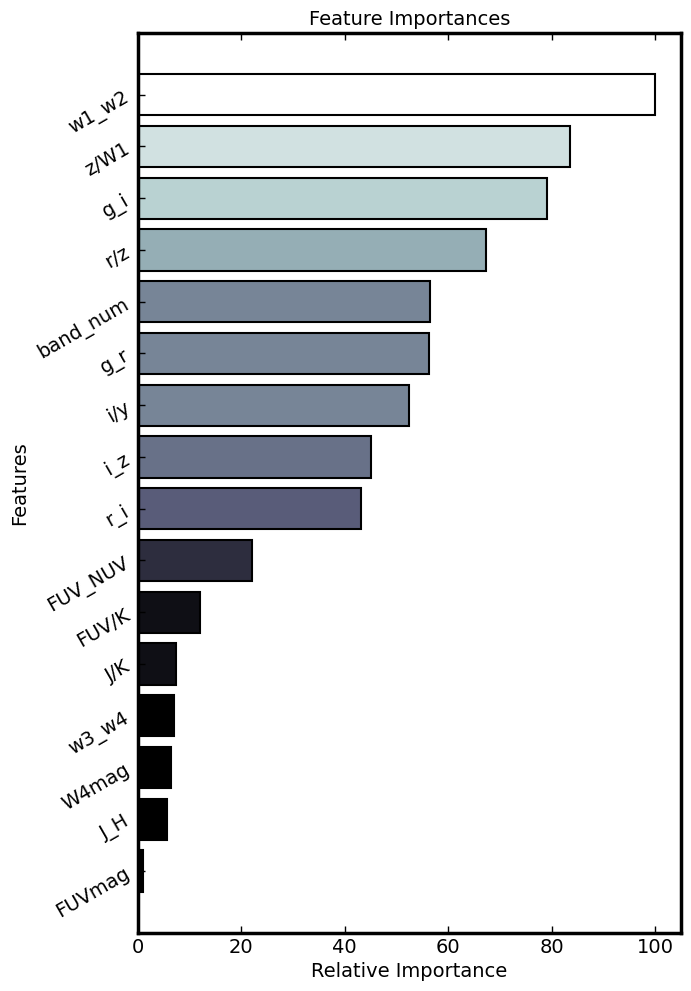

In [60]:
print('Feature importances scaled in [1,100]')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(data_validation_AGN_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, data_validation_AGN_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal  * (100 - 1) + 1,\
             color=plt.get_cmap('bone', len(importances))(import_scal), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('../plots/feat_importance_AGN_HETDEX.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * (100 - 1) + 1)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
w1_w2	15.704
z/W1	13.107
g_i	12.393
r/z	10.517
band_num	8.801
g_r	8.768
i/y	8.179
i_z	7.014
r_i	6.686
FUV_NUV	3.371
FUV/K	1.783
J/K	1.027
w3_w4	0.974
W4mag	0.880
J_H	0.761
FUVmag	0.034


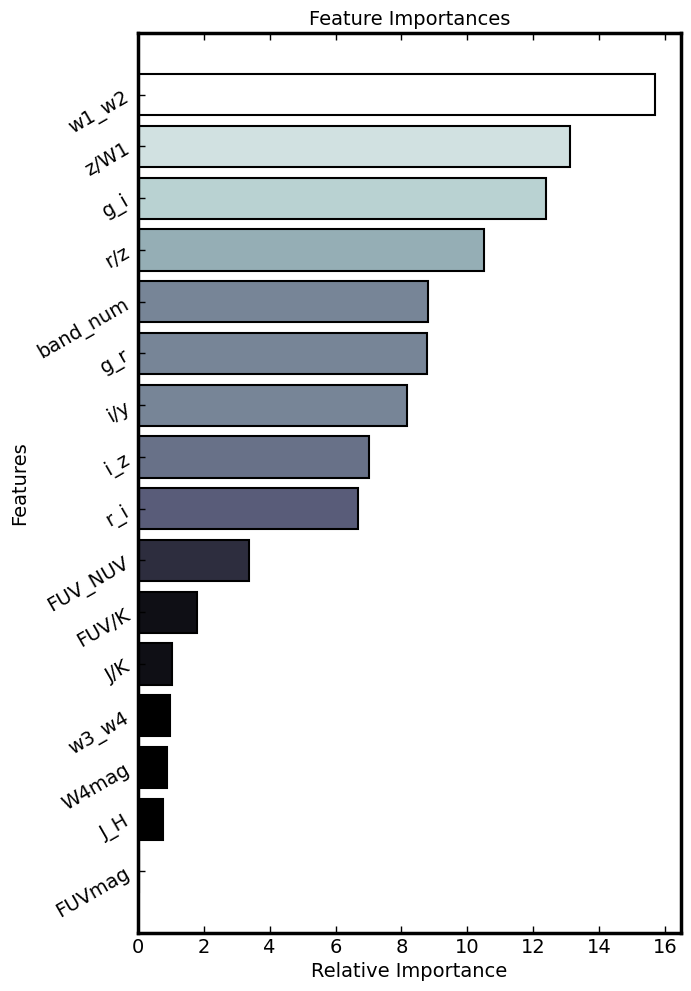

In [61]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(data_validation_AGN_df.columns)
    features_df = get_feature_importances_df(final_AGN_clf, data_validation_AGN_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig('../plots/feat_importance_AGN_HETDEX_perc.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [62]:
AGN_pred_threshold = 0.5
# AGN_pred_threshold = 0.49999523  # from MCC optimisation - From S82 data

In [63]:
validation_prediction_clf = pyc.predict_model(final_AGN_clf, 
                                              data=data_validation_AGN_df, probability_threshold=AGN_pred_threshold, raw_score=True)

Create confusion matrix with validation data.

In [64]:
cm_mat_val = np.array([[np.sum(np.array(validation_prediction_clf['is_AGN'] == 0) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['is_AGN'] == 0) & np.array(validation_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(validation_prediction_clf['is_AGN'] == 1) & np.array(validation_prediction_clf['Label'] == 0)),\
          np.sum(np.array(validation_prediction_clf['is_AGN'] == 1) & np.array(validation_prediction_clf['Label'] ==1))]])

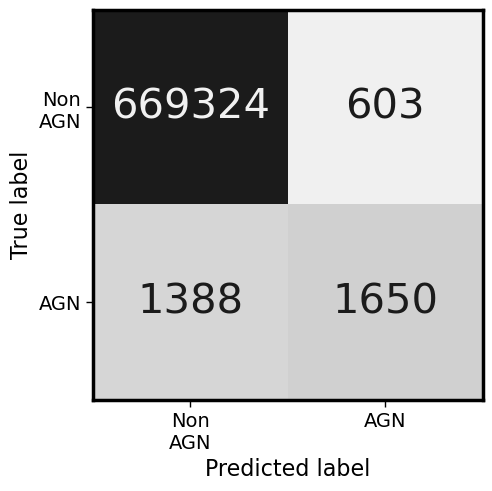

In [65]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_val,
                              display_labels=['Non\nAGN', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('../plots/confusion_matrix_validation_AGN_HETDEX.pdf', bbox_inches='tight')
plt.show()

In [66]:
TN_AGN, FP_AGN, FN_AGN, TP_AGN = cm_mat_val.flatten().astype('float32')

In [67]:
MCC_AGN_val = ((TP_AGN * TN_AGN) - (FP_AGN * FN_AGN)) /\
            np.sqrt((TP_AGN + FP_AGN) * (TP_AGN + FN_AGN) * (TN_AGN + FP_AGN) * (TN_AGN + FN_AGN))

ACC_AGN_val = (TP_AGN + TN_AGN) / (TP_AGN + TN_AGN + FP_AGN + FN_AGN)

F1_AGN_val  = 2 * TP_AGN / (2 * TP_AGN + FP_AGN + FN_AGN)

Recall_AGN_val = TP_AGN / (TP_AGN + FN_AGN)

In [68]:
print('Metrics for Validation set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_val:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_val:.4f}')
print(f'F1-score is F1 = {F1_AGN_val:.4f}')
print(f'Recall is TPR = {Recall_AGN_val:.4f}')

Metrics for Validation set.
Matthews Correlation Coefficient is MCC = 0.6293
Accuracy is ACC = 0.9970
F1-score is F1 = 0.6237
Recall is TPR = 0.5431


In [69]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns = _get_columns_to_stratify_by(
            data_train_test_AGN_df.drop(columns=['is_AGN']), data_train_test_AGN_df.loc[:, 'is_AGN'], False, 'is_AGN'
        )

X_train, X_test, y_train, y_test = train_test_split(
                data_train_test_AGN_df.drop(columns=['is_AGN']),
                data_train_test_AGN_df.loc[:, 'is_AGN'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_data_df        = pd.concat([X_train, y_train], axis=1)
test_data_df         = pd.concat([X_test, y_test], axis=1)

In [70]:
train_prediction_clf = pyc.predict_model(final_AGN_clf, 
                                              data=train_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

In [71]:
test_prediction_clf = pyc.predict_model(final_AGN_clf, 
                                              data=test_data_df, probability_threshold=AGN_pred_threshold, raw_score=True)

In [72]:
cm_mat_train = np.array([[np.sum(np.array(train_prediction_clf['is_AGN'] == 0) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['is_AGN'] == 0) & np.array(train_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(train_prediction_clf['is_AGN'] == 1) & np.array(train_prediction_clf['Label'] == 0)),\
          np.sum(np.array(train_prediction_clf['is_AGN'] == 1) & np.array(train_prediction_clf['Label'] ==1))]])

In [73]:
cm_mat_test = np.array([[np.sum(np.array(test_prediction_clf['is_AGN'] == 0) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['is_AGN'] == 0) & np.array(test_prediction_clf['Label'] ==1))],\
        [np.sum(np.array(test_prediction_clf['is_AGN'] == 1) & np.array(test_prediction_clf['Label'] == 0)),\
          np.sum(np.array(test_prediction_clf['is_AGN'] == 1) & np.array(test_prediction_clf['Label'] ==1))]])

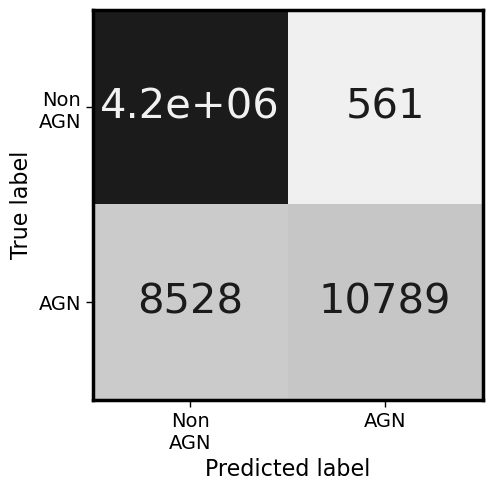

In [74]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_train,
                              display_labels=['Non\nAGN', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('../plots/confusion_matrix_train_AGN_HETDEX.pdf', bbox_inches='tight')
plt.show()

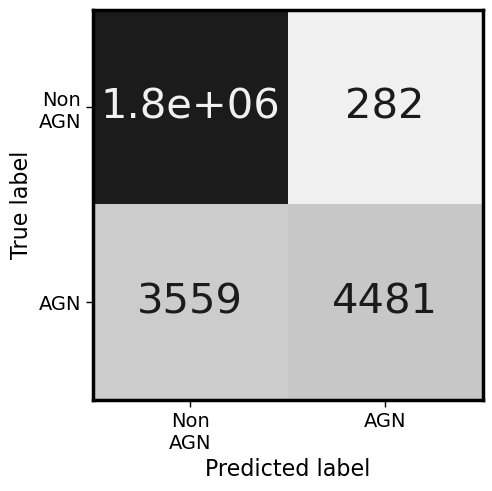

In [75]:
from sklearn.metrics import ConfusionMatrixDisplay

fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mat_test,
                              display_labels=['Non\nAGN', 'AGN'])
norm = ImageNormalize(stretch=LogStretch())

# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp_b = disp.plot(include_values=True,
                 cmap=cm.get_cmap('cet_dimgray_r'), ax=ax1, xticks_rotation='horizontal')

for text_val in disp_b.text_.flatten():
    text_val.set_fontsize(30)
clb = plt.gca().images[-1].colorbar
clb.ax.tick_params(labelsize=14)
clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
clb.outline.set_linewidth(2.5)
clb.ax.set_ylabel('Sources in bin', size=14, path_effects=pe2)
clb.remove()

disp_b.im_.norm = norm

ax1.xaxis.get_label().set_fontsize(16)
ax1.yaxis.get_label().set_fontsize(16)

ax1.tick_params(axis='both', which='major', labelsize=14)

plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.tight_layout()
if save_plot_flag:
    plt.savefig('../plots/confusion_matrix_test_AGN_HETDEX.pdf', bbox_inches='tight')
plt.show()

In [76]:
TN_AGN_train, FP_AGN_train, FN_AGN_train, TP_AGN_train = cm_mat_train.flatten().astype('float32')

In [77]:
MCC_AGN_train = ((TP_AGN_train * TN_AGN_train) - (FP_AGN_train * FN_AGN_train)) /\
            np.sqrt((TP_AGN_train + FP_AGN_train) * (TP_AGN_train + FN_AGN_train) * 
                    (TN_AGN_train + FP_AGN_train) * (TN_AGN_train + FN_AGN_train))

ACC_AGN_train = (TP_AGN_train + TN_AGN_train) / (TP_AGN_train + TN_AGN_train + FP_AGN_train + FN_AGN_train)

F1_AGN_train  = 2 * TP_AGN_train / (2 * TP_AGN_train + FP_AGN_train + FN_AGN_train)

Recall_AGN_train = TP_AGN_train / (TP_AGN_train + FN_AGN_train)

In [78]:
print('Metrics for Training set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_train:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_train:.4f}')
print(f'F1-score is F1 = {F1_AGN_train:.4f}')
print(f'Recall is TPR = {Recall_AGN_train:.4f}')

Metrics for Training set.
Matthews Correlation Coefficient is MCC = 0.7278
Accuracy is ACC = 0.9979
F1-score is F1 = 0.7036
Recall is TPR = 0.5585


In [79]:
TN_AGN_test, FP_AGN_test, FN_AGN_test, TP_AGN_test = cm_mat_test.flatten().astype('float32')

In [80]:
MCC_AGN_test = ((TP_AGN_test * TN_AGN_test) - (FP_AGN_test * FN_AGN_test)) /\
            np.sqrt((TP_AGN_test + FP_AGN_test) * (TP_AGN_test + FN_AGN_test) * 
                    (TN_AGN_test + FP_AGN_test) * (TN_AGN_test + FN_AGN_test))

ACC_AGN_test = (TP_AGN_test + TN_AGN_test) / (TP_AGN_test + TN_AGN_test + FP_AGN_test + FN_AGN_test)

F1_AGN_test  = 2 * TP_AGN_test / (2 * TP_AGN_test + FP_AGN_test + FN_AGN_test)

Recall_AGN_test = TP_AGN_test / (TP_AGN_test + FN_AGN_test)

In [81]:
print('Metrics for Test set.')
print(f'Matthews Correlation Coefficient is MCC = {MCC_AGN_test:.4f}')
print(f'Accuracy is ACC = {ACC_AGN_test:.4f}')
print(f'F1-score is F1 = {F1_AGN_test:.4f}')
print(f'Recall is TPR = {Recall_AGN_test:.4f}')

Metrics for Test set.
Matthews Correlation Coefficient is MCC = 0.7233
Accuracy is ACC = 0.9979
F1-score is F1 = 0.7000
Recall is TPR = 0.5573
